Authors:

Rana Mohamed Barakat (ID:6926), Mohab Mohamed Ali (ID:7199)

## Problem Statement
Speech is the most natural way of expressing ourselves as humans. It is only natural then to extend this communication medium to computer applications. We define speech emotion recognition (SER) systems as a collection of methodologies that process and classify speech signals to detect the embedded emotions. SER is not a new field, it has been around for over two decades, and has regained attention thanks to the recent advancements. We have built different models with different features extracted from audios to try to detect the embedded emotions in each audio. We used the CREMA dataset in this model which can be found [here](https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en).

## Imports

In [880]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
import IPython.display
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [878]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

## Download the Dataset and Understand the Format (10 points)
We start by loading each audio as a normalized numpy array using librosa's load function. We set the duration to 2.5 seconds, and the offset to 0.3. So, 2.5 seconds will be retained from each audio, starting at 0.3 seconds. This is important to ensure that all audios have the same feature space dimensions. However, we can still skip this and retain the whole audio, then pad the feature spaces later on ( We have implemented this as well ).

In [881]:
audios = []
labels = []
audio_files = os.listdir('Crema')
for file in audio_files:
    labels.append(file.split('_')[2])
    # fs,data = wavfile.read(os.path.join('Crema',file))
    data, fs = librosa.load(os.path.join('Crema',file),sr=None,duration=2.5,offset=0.3)
    audios.append([data,fs])
    

In [882]:
aud = []
for audio,fs in audios:
    audio = librosa.util.fix_length(audio, size=35000)
    aud.append([audio,fs])
audios=aud

In [883]:
print(len(labels))
print(len(audios))

7442
7442


In [884]:
audios[1000][0].shape

(35000,)

In [885]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [886]:
fs_list = [x for _,x in audios]
set(fs_list) # all files have a sample rate of 16kHz

{16000}

,data,label
0,"[[0.0006713867, 0.0006713867, 0.00048828125, 0...",ANG
1,"[[0.008575439, 0.008636475, 0.009094238, 0.009...",DIS
2,"[[3.0517578e-05, -0.000579834, -0.0010070801, ...",FEA
3,"[[0.004699707, 0.0038452148, 0.0040283203, 0.0...",HAP
4,"[[0.0045776367, 0.0049438477, 0.0043029785, 0....",NEU
...,...,...
7437,"[[0.0020751953, 0.0020446777, 0.002166748, 0.0...",DIS
7438,"[[-0.004119873, -0.0042419434, -0.004272461, -...",FEA
7439,"[[-0.0035705566, -0.0033569336, -0.0028381348,...",HAP
7440,"[[-0.00894165, -0.008422852, -0.008148193, -0....",NEU


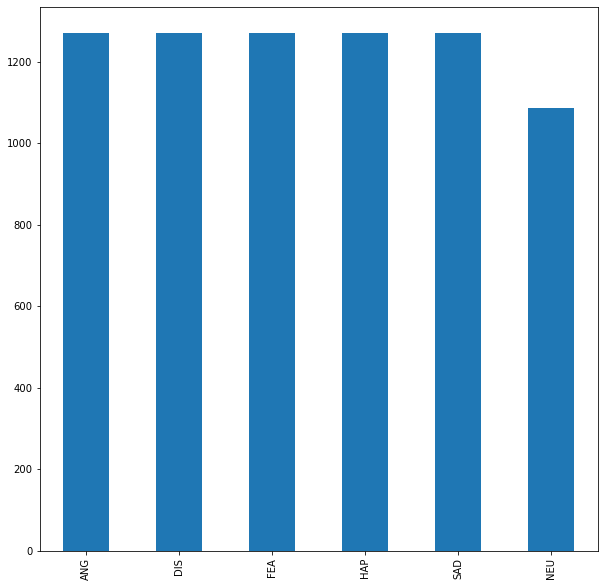

In [887]:
df = pd.concat([pd.Series(audios,name='data'),pd.Series(labels,name='label')],axis=1)
df['label'].value_counts().plot(kind='bar',figsize=(10,10))
df

## Exploring the Dataset
We implement a `load_audio()` function that plots and outputs a random audio of the desired emotion. We also plot the spectrogram of that audio using `create_spectrogram()`.

In [888]:
emotions = {'ANG':'Angry','SAD':'Sad','NEU':'Neutral','HAP':'Happy','FEA':'Fear','DIS':'Disgust'}
colors = {'ANG':'red','SAD':'navy','NEU':'black','HAP':'yellow','FEA':'purple','DIS':'green'}
audioss=[]
for file in audio_files:
    data, fs = librosa.load(os.path.join('Crema',file),sr=None)
    audioss.append({'audio':data,'sr':fs,'label':file.split('_')[2]})


In [900]:
def load_audio(audioss,emotion):

    # audios = list(df[df['label'] == emotion]['data'])
    audios = []
    for a in audioss:
        if a['label'] == emotion:
            audios.append(a)
            
    idx = random.randint(0,len(audios)-1) # choosing a random file of that emotion
    # audio = audios[idx][0]
    audio = audios[idx]['audio']

    # fs = audios[idx][1]
    fs = audios[idx]['sr']

    duration = len(audio)/fs

    time = np.arange(0,duration,1/fs) # time vector

    plt.figure(figsize=(16,8))
    plt.plot(time,audio,color=colors[emotion])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(emotions[emotion] + ' Waveform')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()
    return audio, fs

In [896]:
audioss[0]['label']

'ANG'

In [901]:
def create_spectrogram(data, fs, emotion):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='hz')
    plt.colorbar()

### Angry Emotion

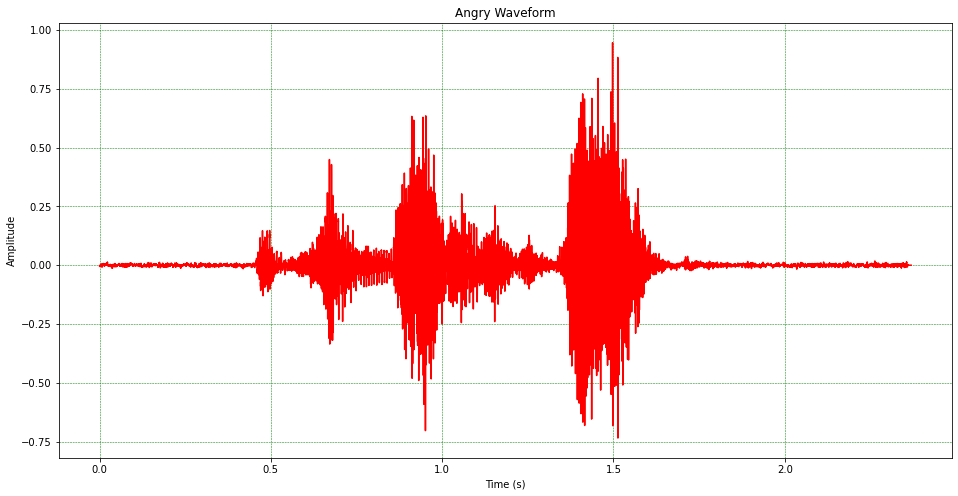

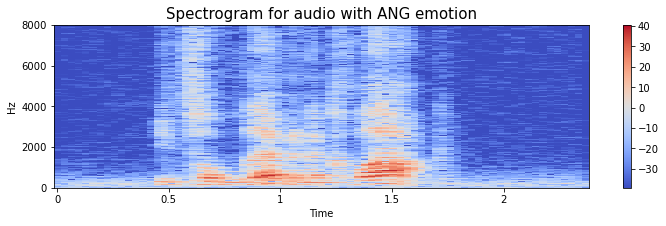

In [902]:
# ANGRY
audio,fs = load_audio(audioss,'ANG')
create_spectrogram(audio,fs,'ANG')
IPython.display.Audio(audio,rate=fs)


### Disgusted Emotion

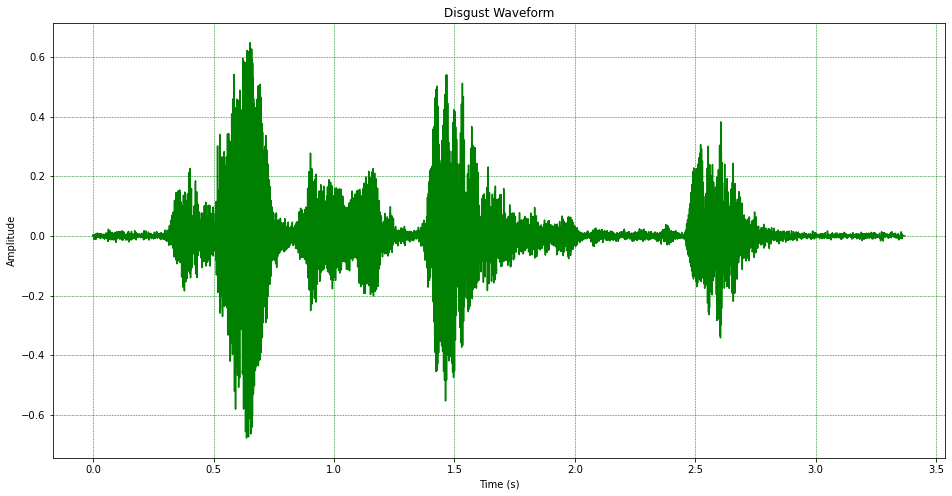

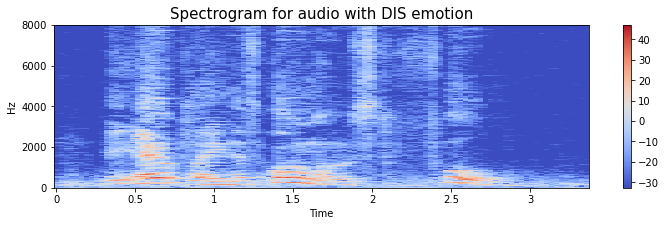

In [903]:
# DISGUSTED 
audio,fs = load_audio(audioss,'DIS')
create_spectrogram(audio,fs,'DIS')
IPython.display.Audio(audio,rate=fs)


### Fear Emotion

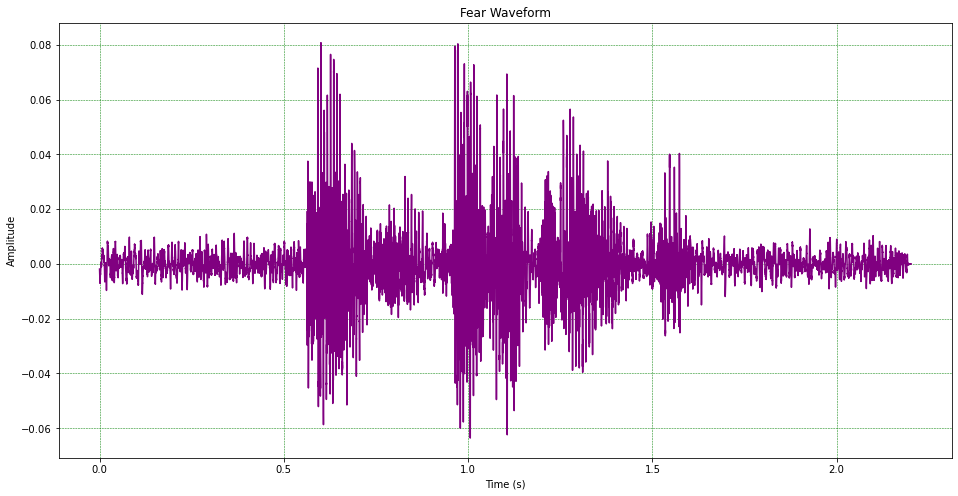

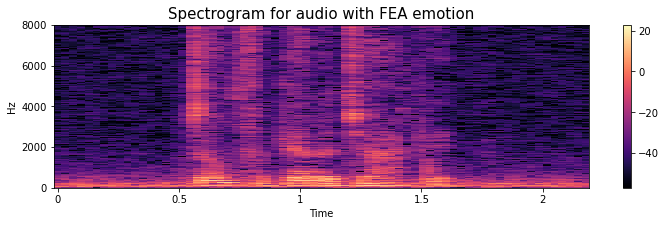

In [904]:
# FEAR
audio,fs = load_audio(audioss,'FEA')
create_spectrogram(audio,fs,'FEA')
IPython.display.Audio(audio,rate=fs)


### Happy Emotion

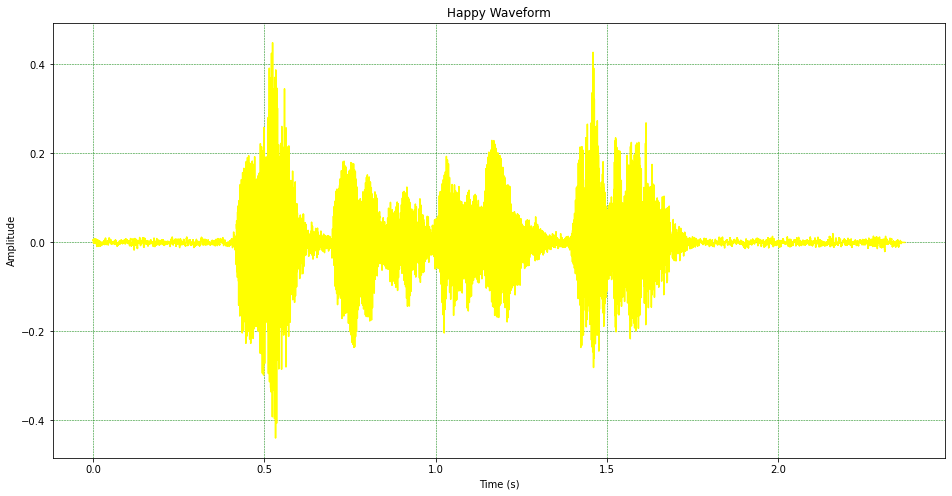

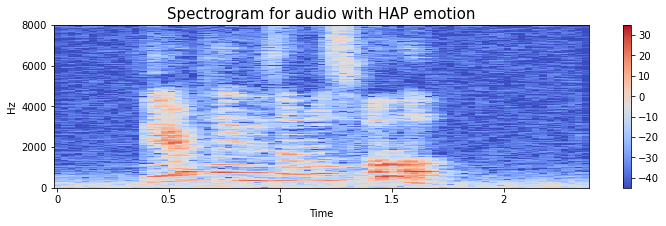

In [906]:
# HAPPY
audio,fs = load_audio(audioss,'HAP')
create_spectrogram(audio,fs,'HAP')
IPython.display.Audio(audio,rate=fs)


### Sad Emotion

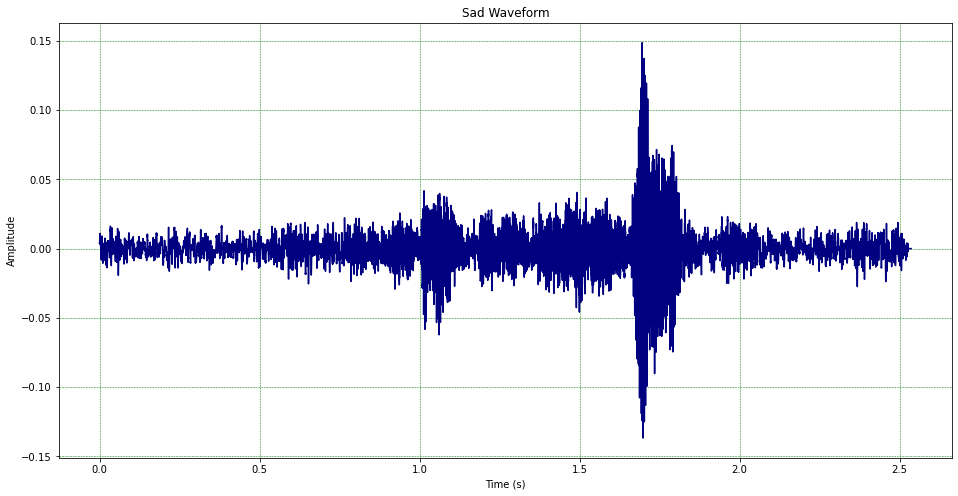

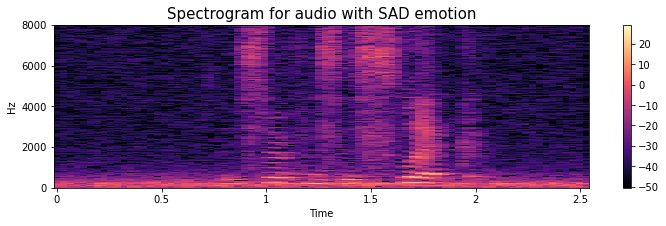

In [907]:
# SAD
audio,fs = load_audio(audioss,'SAD')
create_spectrogram(audio,fs,'SAD')
IPython.display.Audio(audio,rate=fs)

### Neutral Emotion

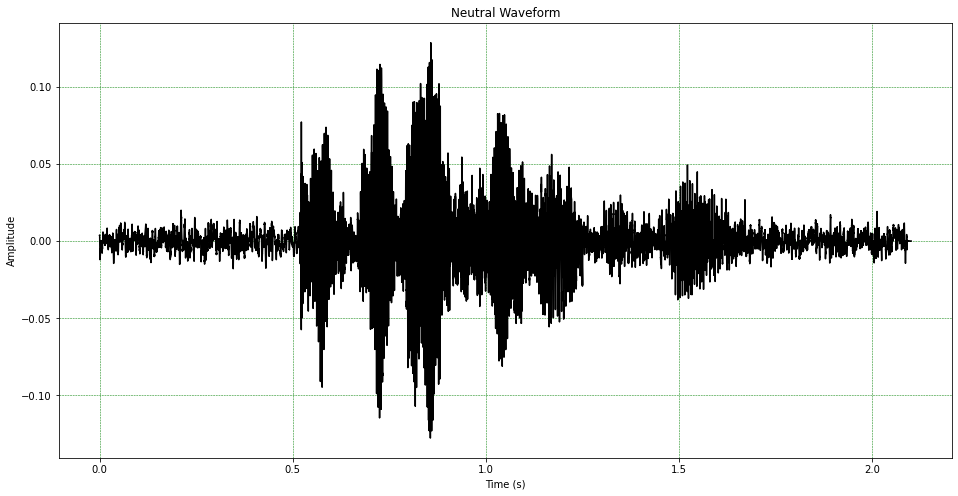

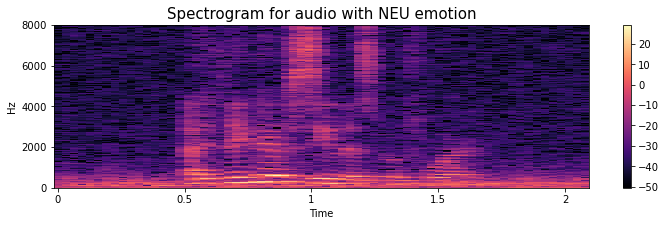

In [908]:
# NEUTRAL
audio,fs = load_audio(audioss,'NEU')
create_spectrogram(audio,fs,'NEU')
IPython.display.Audio(audio,rate=fs)


In [ ]:
# THE FOLLOWING FUNCTION WAS USED TO UNIFY THE SIZE OF FEATURE VECTORS/MATRICES BEFORE USING LIBROSA TO UNIFY THE LENGTH OF THE AUDIOS AT THE BEGINNING. WE DON'T USE THAT NOW. LEFT FOR REFERENCE.
def pad(list,mel_spectrogram=False,max_len=None):
    padded_list = []
    if not mel_spectrogram:
        if max_len == None:
            max_len =  max([i.size for i in list])
        for l in list:
            if not l.size >= max_len:
                padded_list.append(np.pad(l, (0, max_len-l.size), 'constant'))
            else:
                padded_list.append(l[:max_len])
    else:
        if max_len == None:
            max_len =  max([i.shape[0] for i in list])
        for l in list:
            if not l.shape[0] >= max_len:
                padded_list.append(np.pad(l, [(0, max_len-l.shape[0]),(0,0)], mode='constant'))
            else:
                padded_list.append(l[:max_len,:])
    return padded_list,max_len


## Splitting the Dataset into Train, Test and Validation
We split the data into 70% train and validation, and 30% test. Then, we further split the train and validation set into 95% train and 5% vaidation.
We proceed by encoding the labels using sklearn's `LabelEncoder()`.

In [909]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df['data'].to_numpy(), np.array(labels), test_size=0.3, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42,stratify=y_trainval)

In [910]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

## Create the Feature Space (30 Points) 
We experimented with many feature combinations and tried multiple dimensionality reduction techniques (i.e PCA, LDA) to try to capture trends and temporal patterns in speech emotion changes. We created two feature spaces, a 1-dimensional feature space, and a 2-dimensional one. Here are some features we tried:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.

2. Energy : The sum of squares of the signal values, normalized by the respective frame length.

3. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.

4. MFCCs: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

5. Delta MFCC: In addition to the MFCC features, these features capture the changes in the MFCC coefficients over time, providing more information about the speech signal dynamics.

6. Chroma Features: Chroma features such as chroma energy and chroma deviation can provide useful information related to the pitch content or musicality of speech, which may be relevant for certain emotional states or variations in speech patterns.

7. Pitch mean, standard deviation, and range.


After many experimentations, we were able to yield the best results using ZCR, ENERGY, MFCCS, and SPECTRAL ROLLOFF with no dimensionality reduction. (1-dimensional feature space)

The 2-dimensional feature space consisted of the mel spectrogram of each audio with `n_mels=128`.

`Note: We tried using zcr, energy, and specral rolloff as arrays and as mean values. Mean values provide a global summary of the feature, while using an array of values captures the temporal dynamics. We settled on incorporating them as arrays.`

In [ ]:

# OBSOLETE. LEFT FOR REFERENCE.

def create_feature_space(X,y=None,mel_spectrogram=False,training = False, max_len_zcr=None,max_len_en=None,max_len_mfccs=None,max_len_mel=None,clf=None,mean=None,stddev=None):
    # labels = []
    if not mel_spectrogram: # time/freq domain feature space
        feature_space = []
        zcrs=[]
        energies=[]
        mfccs=[]
        rolloff=[]
        # lfccs = []
        # transform = transforms.LFCC(
        # speckwargs={"n_fft": 400, "hop_length": 512, "center": False})
        for i,data in enumerate(X):
            # audio = np.array(data[0][0],dtype='float')
            audio = data[0]
            fs = data[1]
            # zero_crosses = np.nonzero(np.diff(audio > 0))[0]
            # zcr = zero_crosses.size/len(audio) # zero crossing rate

            # zero crossing rate
            # zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=512))
            zcr=np.mean(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=512).T,axis=0)

            # print(zcr.shape)
            zcrs.append(zcr)

            # normalized energy
            # energy=np.squeeze(librosa.feature.rms(y=audio,frame_length=2048,hop_length=512))
            # energy = np.array([sum(audio[j:j+2048]**2)/2048 for j in range(0, len(audio), 512)])
            # print(energy.shape)
            energy=np.mean(librosa.feature.rms(y=audio,frame_length=2048,hop_length=512).T,axis=0)
            energies.append(energy)

            # mel frequency cepstral coefficient (MFCC)
            mfcc=np.ravel(librosa.feature.mfcc(y=audio,sr=fs).T)
            # print(mfcc.shape)
            mfccs.append(mfcc)

            roll = np.squeeze(librosa.feature.spectral_rolloff(y=audio, sr=fs,hop_length=512))
            rolloff.append(roll)
            
            # lfcc = transform(tf.convert_to_tensor(audio)[0])
            # lfccs.append(lfcc.numpy())
            
            # feature_space.append(np.concatenate((zcr,energy,mfcc), axis=None))
            # labels.append(data[1])

            if i%1000==0:
                print(f'audio #{i} checkpoint')

        # max_len = max([len(i) for i in zcrs]) # find the longest list of scr to pad the others until they have equal length
        # if not training:
        #     zcrs,_ = pad(zcrs,max_len=max_len_zcr)
        #     energies,_ = pad(energies,max_len=max_len_en)
        #     mfccs,_ = pad(mfccs,max_len=max_len_mfccs)
        # else:
        #     zcrs,max_len_z = pad(zcrs)
        #     energies,max_len_e = pad(energies)
        #     mfccs,max_len_m = pad(mfccs)

        # lfccs = pad(lfccs)

        for i in range(X.shape[0]):
            # feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],lfccs[i]), axis=None))
            feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],rolloff[i]), axis=None))

        # labels = np.array(labels)
        feature_space = np.array(feature_space)
        # if training:
            # clf = LinearDiscriminantAnalysis(n_components=5).fit(feature_space,y)
            # feature_space=clf.transform(feature_space)
            # return feature_space,max_len_z,max_len_e,max_len_m,clf
            # return feature_space,clf
        # else:
            # feature_space=clf.transform(feature_space)
        return feature_space
    else:
        mels=[]
        for i,data in enumerate(X):
            audio = data[0]
            fs = data[1]
            mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=2048,n_mels=128).T
            # mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=128)
            # mel_db = librosa.power_to_db(mel, ref=np.max)
            mels.append(mel)
            # labels.append(data[1])
            if i%1000==0:
                print(f'audio #{i} checkpoint')
        mels=np.array(mels)
        # if training:
            # mels,max_len_mels = pad(mels,mel_spectrogram=True)
            # mean_value = np.mean(mels,axis=0)
            # std_value = np.std(mels,axis=0)
            # norm_mels = (mels - mean_value) / std_value
            # return norm_mels,max_len_mels,mean_value,std_value
            # return norm_mels,mean_value,std_value

        # else:
            # mels,_ = pad(mels,mel_spectrogram=True,max_len=max_len_mel)
            # norm_mels = (mels - mean) / stddev
        return mels



In [931]:
def extract_features(audio,mel_spectrogram=False):
    if not mel_spectrogram:
        result = np.array([])
        
        # zcr=np.mean(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=512).T,axis=0)
        zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=512))

        result = np.hstack((result,zcr))
        
        # rms = np.mean(librosa.feature.rms(y=audio,frame_length=2048,hop_length=512).T ,axis=0)
        rms = np.squeeze(librosa.feature.rms(y=audio,frame_length=2048,hop_length=512))

        result = np.hstack((result, rms))

        # rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=16000,n_fft=2048,hop_length=512).T,axis=0)
        rolloff = np.squeeze(librosa.feature.spectral_rolloff(y=audio, sr=16000,n_fft=2048,hop_length=512))

        result = np.hstack((result, rolloff))

        # stft = np.abs(librosa.stft(audio))
        # chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=16000).T, axis=0)
        # result = np.hstack((result, chroma_stft))

        # mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=16000).T, axis=0)
        mfcc = np.ravel(librosa.feature.mfcc(y=audio, sr=16000).T)
        result = np.hstack((result, mfcc))

        # delta_mfcc = np.mean(librosa.feature.delta(mfcc).T,axis=0)
        # result = np.hstack((result, delta_mfcc))

        # delta2_mfcc = np.mean(librosa.feature.delta(mfcc, order=2).T,axis=0)
        # result = np.hstack((result, delta2_mfcc))

        # Extract chroma features
        # chroma = librosa.feature.chroma_stft(y=audio, sr=16000)
        # chroma_energy = np.mean(chroma, axis=1)
        # # chroma_deviation = np.std(chroma, axis=1)
        # result = np.hstack((result, chroma_energy))
        # result = np.hstack((result, chroma_deviation))

        # pitch, magnitudes = librosa.core.piptrack(y=audio, sr=16000)
        # pitch_mean = np.mean(pitch, axis=0)
        # pitch_std = np.std(pitch, axis=0)
        # pitch_range = np.max(pitch, axis=0) - np.min(pitch, axis=0)
        # result = np.hstack((result, pitch_mean))
        # result = np.hstack((result, pitch_std))
        # result = np.hstack((result, pitch_range))
        return result

    else:
        mel = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=2048)
        return mel

In [912]:
X_trainn = np.array(np.array([x for x,_ in X_train]))
X_testt = np.array(np.array([x for x,_ in X_test]))
X_vall = np.array(np.array([x for x,_ in X_val]))

In [ ]:
sc=StandardScaler()
X_trainn=sc.fit_transform(X_trainn)
X_testt=sc.transform(X_testt)
X_vall=sc.transform(X_vall)

In [ ]:
# Apply data augmentation techniques (example: random cropping)
def random_crop(mel_spectrogram, crop_size):
    h, w = mel_spectrogram.shape
    max_x = h - crop_size
    max_y = w - crop_size
    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)
    cropped = mel_spectrogram[x:x+crop_size, y:y+crop_size]
    return cropped

In [ ]:
features_train = []
features_test = []
features_val = []

for i in range(X_trainn.shape[0]):
    features_train.append(extract_features(X_trainn[i]))
for i in range(X_testt.shape[0]):
    features_test.append(extract_features(X_testt[i]))
for i in range(X_vall.shape[0]):
    features_val.append(extract_features(X_vall[i]))


In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)
features_val = np.array(features_val)


In [ ]:
X_trainn = np.array(np.array([x for x,_ in X_train]))
X_testt = np.array(np.array([x for x,_ in X_test]))
X_vall = np.array(np.array([x for x,_ in X_val]))

In [932]:
mels_train = []
mels_test=[]
mels_val=[]
for i in range(X_trainn.shape[0]):
    mels_train.append(extract_features(X_trainn[i],mel_spectrogram=True))
for i in range(X_testt.shape[0]):
    mels_test.append(extract_features(X_testt[i],mel_spectrogram=True))
for i in range(X_vall.shape[0]):
    mels_val.append(extract_features(X_vall[i],mel_spectrogram=True))


In [933]:
mels_train=np.array(mels_train)
mels_test = np.array(mels_test)
mels_val=np.array(mels_val)

In [935]:
mels_train = np.expand_dims(mels_train,axis=3)
mels_test = np.expand_dims(mels_test,axis=3)
mels_val = np.expand_dims(mels_val,axis=3)


In [936]:
mels_train.shape

(4948, 128, 69, 1)

In [ ]:
# lda = LinearDiscriminantAnalysis(n_components=5).fit(features_train,y_train)
# features_trainn = lda.transform(features_train)
# features_testt = lda.transform(features_test)
# features_vall = lda.transform(features_val)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
features_trainn = pca.fit_transform(X_trainn)
features_testt = pca.transform(X_testt)
features_vall = pca.transform(X_vall)

## Building the Model (40 points)
We tried two different models for the 1-dimensional feature space. The major difference was that one of the models had LSTM layers while the other did not. Also, the model with no LSTM layers was much deeper, with 5,554,310 trainable parameters in contrast to just 189,190 trainable parameters. Obviously, The model with LSTM layers was much faster, and actually yielded better results. We were able to reach a test accuracy of 52.53% using that model. The other model yielded a test accuracy of 50.8%

In [917]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=20,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.75,min_lr=0.000001)

In [ ]:
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(features_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Dropout(0.3),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['acc'])
model.summary()


Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_386 (Conv1D)         (None, 1587, 512)         3072      
                                                                 
 batch_normalization_446 (Ba  (None, 1587, 512)        2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_377 (MaxPooli  (None, 794, 512)         0         
 ng1D)                                                           
                                                                 
 conv1d_387 (Conv1D)         (None, 794, 512)          1311232   
                                                                 
 batch_normalization_447 (Ba  (None, 794, 512)         2048      
 tchNormalization)                                               
                                                    

In [ ]:
# Define the model architecture
modelopt = Sequential()
modelopt.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(features_train.shape[1], 1)))
modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
# modelopt.add(BatchNormalization())
modelopt.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
# modelopt.add(BatchNormalization())
modelopt.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
# modelopt.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
# modelopt.add(MaxPooling1D(pool_size=2,padding='same'))
modelopt.add(LSTM(64, return_sequences=True))
modelopt.add(LSTM(64))
# modelopt.add(Dropout(0.5))
modelopt.add(Dense(256, activation='relu'))#, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
# modelopt.add(Dropout(0.5))
modelopt.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelopt.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['acc'])
modelopt.summary()

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_391 (Conv1D)         (None, 1583, 32)          192       
                                                                 
 max_pooling1d_382 (MaxPooli  (None, 792, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_392 (Conv1D)         (None, 790, 64)           6208      
                                                                 
 max_pooling1d_383 (MaxPooli  (None, 395, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_393 (Conv1D)         (None, 393, 256)          49408     
                                                                 
 max_pooling1d_384 (MaxPooli  (None, 197, 256)      

In [ ]:
histopt = modelopt.fit(features_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])

Epoch 1/100
39/39 [==============================] - 79s 2s/step - loss: 1.7608 - acc: 0.2439 - val_loss: 1.7191 - val_acc: 0.2759 - lr: 1.0000e-04
Epoch 2/100
39/39 [==============================] - 79s 2s/step - loss: 1.6673 - acc: 0.3193 - val_loss: 1.5996 - val_acc: 0.3257 - lr: 1.0000e-04
Epoch 3/100
39/39 [==============================] - 74s 2s/step - loss: 1.5714 - acc: 0.3660 - val_loss: 1.5106 - val_acc: 0.4023 - lr: 1.0000e-04
Epoch 4/100
39/39 [==============================] - 74s 2s/step - loss: 1.5014 - acc: 0.4072 - val_loss: 1.4872 - val_acc: 0.3831 - lr: 1.0000e-04
Epoch 5/100
39/39 [==============================] - 74s 2s/step - loss: 1.4742 - acc: 0.4119 - val_loss: 1.4562 - val_acc: 0.3985 - lr: 1.0000e-04
Epoch 6/100
39/39 [==============================] - 74s 2s/step - loss: 1.4535 - acc: 0.4214 - val_loss: 1.4534 - val_acc: 0.4061 - lr: 1.0000e-04
Epoch 7/100
39/39 [==============================] - 74s 2s/step - loss: 1.4447 - acc: 0.4240 - val_loss: 1.4236

In [ ]:
histopt = modelopt.fit(features_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])

Epoch 1/50
39/39 [==============================] - 71s 2s/step - loss: 1.6248 - acc: 0.3207 - val_loss: 1.4396 - val_acc: 0.4253 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 71s 2s/step - loss: 1.4346 - acc: 0.4236 - val_loss: 1.3934 - val_acc: 0.4713 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 73s 2s/step - loss: 1.3835 - acc: 0.4491 - val_loss: 1.3718 - val_acc: 0.4598 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 70s 2s/step - loss: 1.3553 - acc: 0.4721 - val_loss: 1.3697 - val_acc: 0.4751 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 70s 2s/step - loss: 1.3730 - acc: 0.4612 - val_loss: 1.3567 - val_acc: 0.4483 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 72s 2s/step - loss: 1.3154 - acc: 0.4800 - val_loss: 1.3859 - val_acc: 0.4406 - lr: 1.0000e-04
Epoch 7/50
39/39 [==============================] - 72s 2s/step - loss: 1.3030 - acc: 0.4861 - val_loss: 1.3745 - val_

In [ ]:
histopt = modelopt.fit(features_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])

## Big Picture (20 Points) 
#### 1. TESTING THE FIRST MODEL ON 1-DIMENSIONAL FEATURE VECTORS
    We compute the accuracy, f1-score, precision, recall and loss on test data based on our model. We also plot the journey of accuracies and losses, and visualize the confusion matrix for the test results.

In [ ]:
loss,accuracy=modelopt.evaluate(features_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy*100}%')

Test Loss: 1.2662875652313232
Test Accuracy: 52.53022909164429%


In [ ]:
import plotly.express as px
fig=px.line(histopt.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'Epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
fig=px.line(histopt.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=(f'Epoch loss and validation loss chart for the model'))
fig.show()

In [ ]:
import plotly.express as px
fig=px.line(histopt.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'Epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
fig=px.line(histopt.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=(f'Epoch loss and validation loss chart for the model'))
fig.show()

70/70 [==============================] - 19s 239ms/step


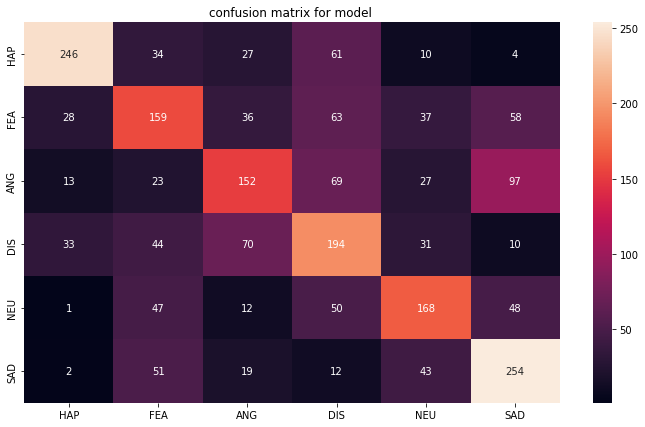

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = modelopt.predict(features_test)
y_pred = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in set(labels)],
    columns=[i for i in set(labels)]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score
prec=precision_score(y_test,y_pred,average='weighted')
rec=recall_score(y_test,y_pred,average='weighted')
f1score=f1_score(y_test,y_pred,average='weighted')
print(f'Test precision: {prec}')
print(f'Test recall: {rec}')
print(f'Test f1-score: {f1score}')

Test precision: 0.5316831795330076
Test recall: 0.5253022839229736
Test f1-score: 0.5252374785837246


#### 2. TESTING THE SECOND MODEL ON 1-DIMENSIONAL FEATURE VECTORS

In [ ]:
hist = model.fit(features_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])

Epoch 1/100
39/39 [==============================] - 23s 450ms/step - loss: 1.9096 - acc: 0.3013 - val_loss: 5.0133 - val_acc: 0.1724 - lr: 1.0000e-04
Epoch 2/100
39/39 [==============================] - 17s 433ms/step - loss: 1.7263 - acc: 0.3373 - val_loss: 2.0859 - val_acc: 0.2299 - lr: 1.0000e-04
Epoch 3/100
39/39 [==============================] - 17s 443ms/step - loss: 1.6632 - acc: 0.3559 - val_loss: 1.8614 - val_acc: 0.1724 - lr: 1.0000e-04
Epoch 4/100
39/39 [==============================] - 17s 430ms/step - loss: 1.6164 - acc: 0.3612 - val_loss: 1.6996 - val_acc: 0.2567 - lr: 1.0000e-04
Epoch 5/100
39/39 [==============================] - 17s 433ms/step - loss: 1.5683 - acc: 0.3775 - val_loss: 1.6211 - val_acc: 0.3333 - lr: 1.0000e-04
Epoch 6/100
39/39 [==============================] - 17s 426ms/step - loss: 1.5800 - acc: 0.3705 - val_loss: 1.5418 - val_acc: 0.3180 - lr: 1.0000e-04
Epoch 7/100
39/39 [==============================] - 17s 429ms/step - loss: 1.5425 - acc: 0.38

In [ ]:
import plotly.express as px
fig=px.line(hist.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
fig=px.line(hist.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model')
fig.show()

In [ ]:
hist2 = model.fit(features_train, y_train, batch_size=64, epochs=50, verbose=1, validation_data=(features_val, y_val), callbacks=[early_stop,lr_reduction])


Epoch 1/50
78/78 [==============================] - 167s 2s/step - loss: 1.9794 - acc: 0.2850 - val_loss: 2.4579 - val_acc: 0.2452 - lr: 1.0000e-04
Epoch 2/50
78/78 [==============================] - 167s 2s/step - loss: 1.7202 - acc: 0.3432 - val_loss: 1.9398 - val_acc: 0.2452 - lr: 1.0000e-04
Epoch 3/50
78/78 [==============================] - 169s 2s/step - loss: 1.6271 - acc: 0.3652 - val_loss: 1.7943 - val_acc: 0.2375 - lr: 1.0000e-04
Epoch 4/50
78/78 [==============================] - 167s 2s/step - loss: 1.5450 - acc: 0.3884 - val_loss: 1.7942 - val_acc: 0.2912 - lr: 1.0000e-04
Epoch 5/50
78/78 [==============================] - 170s 2s/step - loss: 1.5145 - acc: 0.4014 - val_loss: 1.4952 - val_acc: 0.3602 - lr: 1.0000e-04
Epoch 6/50
78/78 [==============================] - 163s 2s/step - loss: 1.4731 - acc: 0.4101 - val_loss: 1.5317 - val_acc: 0.3602 - lr: 1.0000e-04
Epoch 7/50
78/78 [==============================] - 163s 2s/step - loss: 1.4392 - acc: 0.4169 - val_loss: 1.5331

In [ ]:
fig=px.line(hist2.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
fig=px.line(hist2.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model')
fig.show()

In [ ]:
loss,accuracy=model.evaluate(features_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 1.3888615369796753
Test Accuracy: 0.4455888867378235


70/70 [==============================] - 14s 192ms/step


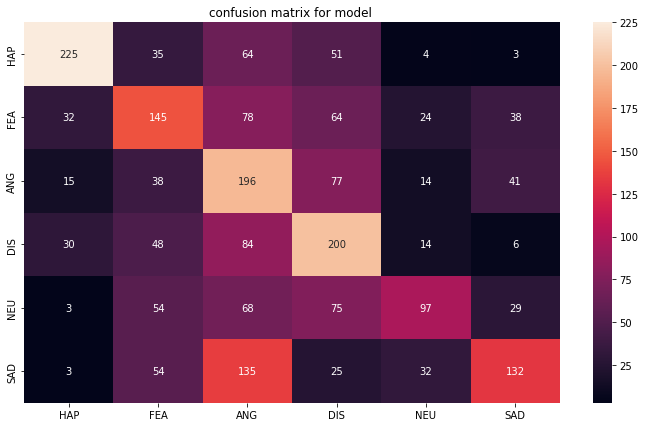

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(features_test)
y_pred = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in set(labels)],
    columns=[i for i in set(labels)]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [938]:
model2D=tf.keras.Sequential([
    L.Conv2D(32,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(mels_train.shape[1],mels_train.shape[2],1)),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    L.Conv2D(64,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    # L.Conv2D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.Conv2D(128,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=3,strides=2,padding='same'),
    L.Conv2D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool2D(pool_size=3,strides=2,padding='same'),

    # L.Conv2D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    # L.BatchNormalization(),
    # L.MaxPool2D(pool_size=5,strides=2,padding='same'),
    # L.Conv2D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    # L.BatchNormalization(),
    # L.GlobalAveragePooling2D(),

    
    L.Flatten(),
    # L.Dropout(rate=0.1),
    # L.Dense(512,activation='relu'),
    L.Dense(512,activation='relu'),
    # L.BatchNormalization(),
    # L.Dense(64,activation='relu'),
    # L.BatchNormalization(),
    L.Dropout(0.3),
    L.Dense(6,activation='softmax')
])
# model2D.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='acc')
# model2D.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2D.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['acc'])
model2D.summary()

Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_169 (Conv2D)         (None, 128, 69, 32)       832       
                                                                 
 batch_normalization_521 (Ba  (None, 128, 69, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 64, 35, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_170 (Conv2D)         (None, 64, 35, 64)        51264     
                                                                 
 batch_normalization_522 (Ba  (None, 64, 35, 64)       256       
 tchNormalization)                                               
                                                    

In [939]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=20,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.75,min_lr=0.000001)

In [922]:
history2D = model2D.fit(mels_train, y_train, batch_size=128, epochs=70, verbose=1, validation_data=(mels_val, y_val), callbacks = [early_stop, lr_reduction])

Epoch 1/70
39/39 [==============================] - 118s 3s/step - loss: 88.2459 - acc: 0.3250 - val_loss: 84.9503 - val_acc: 0.3027 - lr: 1.0000e-04
Epoch 2/70
39/39 [==============================] - 112s 3s/step - loss: 80.0816 - acc: 0.3965 - val_loss: 76.0143 - val_acc: 0.3103 - lr: 1.0000e-04
Epoch 3/70
39/39 [==============================] - 117s 3s/step - loss: 71.8992 - acc: 0.4190 - val_loss: 68.1409 - val_acc: 0.2874 - lr: 1.0000e-04
Epoch 4/70
39/39 [==============================] - 122s 3s/step - loss: 63.9588 - acc: 0.4274 - val_loss: 60.2869 - val_acc: 0.2605 - lr: 1.0000e-04
Epoch 5/70
39/39 [==============================] - 122s 3s/step - loss: 56.3771 - acc: 0.4376 - val_loss: 52.8989 - val_acc: 0.3372 - lr: 1.0000e-04
Epoch 6/70
39/39 [==============================] - 121s 3s/step - loss: 49.3156 - acc: 0.4523 - val_loss: 46.1609 - val_acc: 0.3027 - lr: 1.0000e-04
Epoch 7/70
39/39 [==============================] - 121s 3s/step - loss: 42.8162 - acc: 0.4527 - val

In [940]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model2D.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['acc'])
history2D = model2D.fit(mels_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(mels_val, y_val), callbacks = [early_stop, lr_reduction])

Epoch 1/50
39/39 [==============================] - 110s 3s/step - loss: 2.1346 - acc: 0.3454 - val_loss: 4.3059 - val_acc: 0.2529 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 109s 3s/step - loss: 1.6300 - acc: 0.3842 - val_loss: 1.6857 - val_acc: 0.3295 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 110s 3s/step - loss: 1.4706 - acc: 0.4143 - val_loss: 1.6260 - val_acc: 0.3027 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 109s 3s/step - loss: 1.4532 - acc: 0.4347 - val_loss: 1.7235 - val_acc: 0.2874 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 105s 3s/step - loss: 1.4218 - acc: 0.4359 - val_loss: 1.5401 - val_acc: 0.3372 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 102s 3s/step - loss: 1.3717 - acc: 0.4525 - val_loss: 1.6128 - val_acc: 0.2835 - lr: 1.0000e-04
Epoch 7/50
39/39 [==============================] - 102s 3s/step - loss: 1.3391 - acc: 0.4600 - val_loss: 1.6166

#### 3. TESTING THE 2D CNN MODEL ON THE 2-DIMENSIONAL FEATURE MATRICES

Test Loss: 2.3409640789031982
Test Accuracy: 45.947155356407166%
70/70 [==============================] - 7s 99ms/step


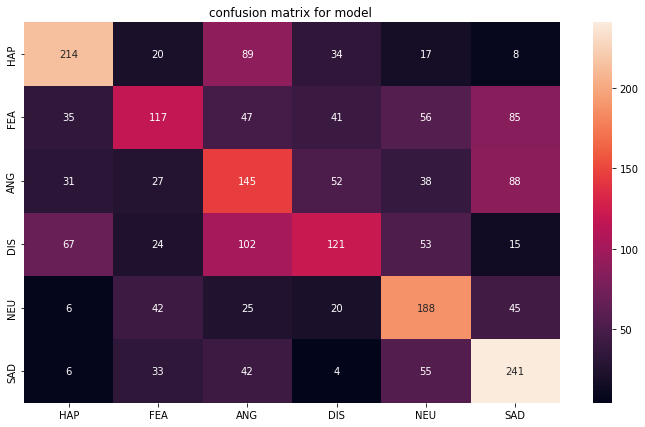

In [ ]:
loss,accuracy=model2D.evaluate(mels_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy*100}%')
y_pred = model2D.predict(mels_test)
y_pred = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in set(labels)],
    columns=[i for i in set(labels)]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [926]:
from sklearn.metrics import f1_score,precision_score,recall_score
prec=precision_score(y_test,y_pred,average='weighted')
rec=recall_score(y_test,y_pred,average='weighted')
f1score=f1_score(y_test,y_pred,average='weighted')
print(f'Test precision: {prec:0,.4f}')
print(f'Test recall: {rec:0,.4f}')
print(f'Test f1-score: {f1score:0,.4f}')

Test precision: 0.4976
Test recall: 0.4569
Test f1-score: 0.4764


In [928]:
fig=px.line(history2D.history,y=['acc','val_acc'],
           labels={'index':'epoch','value':'acc'},
           title=f'Epoch train accuracy and validation accuracy chart')
fig.show()

In [929]:
fig=px.line(history2D.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'Epoch train loss and validation loss chart')
fig.show()